In [1]:
# https://github.com/Grillard/GalfitPyWrap may be useful for setting up inputs
import sys
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii
from astropy import wcs
from astropy.table import Table, hstack, join
import pickle
import os
from __future__ import division
import fnmatch
import multiprocessing as mp
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Load candels morphology catalog

In [15]:
# Load cosmos catalog
cos_cat = '/data/emiln/XLSSU122/analysis/allfields_candels/vdwel/Downloads/cos_2epoch_wfc3_f125w_060mas_v1.0_galfit.cat'
cos_df = pd.read_csv(cos_cat,header=0,delim_whitespace=True,skiprows=[1])
cos_df2 = cos_df[cos_df.columns[:-1]]
cos_df2.columns = cos_df.columns[1:]
cos_df = cos_df2
cos_df_OG = cos_df
print len(cos_df)
# cos_df = cos_df[(cos_df['mag']<23) & (cos_df['f']==0)] # Let's focus on objects brighter than mag 23 for now
# cos_df = cos_df[(cos_df['mag']>21) & (cos_df['f']==0)] # Let's focus on objects brighter than mag 23 for now
# cos_df = cos_df[(cos_df['mag']<21) & (cos_df['f']==0)] # Let's focus on objects brighter than mag 23 for now

# cos_df = cos_df[(cos_df['dn']/cos_df['n'])<1] # Filter out objects with > 100% error
# f=0 are all "good fits" https://users.ugent.be/~avdrwel/data/readme_candels.txt
print len(cos_df)
cos_df.columns.values
print len(cos_df_OG)
print cos_df.columns.values

38671
38671
38671
['NUMBER' 'RA' 'DEC' 'f' 'mag' 'dmag' 're' 'dre' 'n' 'dn' 'q' 'dq' 'pa'
 'dpa' 'sn']


### Load cosmos photometric catalogs

In [16]:
# https://archive.stsci.edu/missions/hlsp/candels/cosmos/catalogs/v1/hlsp_candels_hst_wfc3_cos-tot-multiband_f160w_v1_readme.pdf
# https://archive.stsci.edu/missions/hlsp/candels/cosmos/catalogs/v1/hlsp_candels_hst_wfc3_cos_v1_physpar_readme.pdf

# FLUX RADIUS 2 F160W - half light radius in F160W band (pixels)
# KRON_RADIUS - Sextrator KRON radius (pixels)

# cos_photo_file = 'catalogs/hlsp_candels_hst_wfc3_cos-tot-multiband_f160w_v1_cat.txt'
# cos_photoz_file = 'catalogs/hlsp_candels_hst_wfc3_cos_v1_photoz_cat.txt'

cos_photo_file_fits = 'catalogs/hlsp_candels_hst_wfc3_cos-tot-multiband_f160w_v1_cat.fits'
cos_photoz_file_fits = 'catalogs/hlsp_candels_hst_wfc3_cos_v1_photoz_cat.fits'

# cos_photo_df = pd.read_csv(cos_photo_file,header=0,delim_whitespace=True,skiprows=353)
# cos_photo_df = pd.read_csv(cos_photo_file,header=0,delimiter=' ',skiprows=352)
# cos_photo_df

tab = Table.read(cos_photo_file_fits)
cos_photo_df = tab.to_pandas()

tab = Table.read(cos_photoz_file_fits)
cos_photoz_df = tab.to_pandas()

mdf = cos_photo_df.merge(cos_photoz_df,on='ID')

print mdf.columns.values
print len(cos_photo_df)
print len(mdf)

['ID' 'IAU_designation' 'RA' 'DEC' 'APCOR' 'CFHT_uS_FLUX'
 'CFHT_uS_FLUXERR' 'CFHT_gS_FLUX' 'CFHT_gS_FLUXERR' 'CFHT_rS_FLUX'
 'CFHT_rS_FLUXERR' 'CFHT_iS_FLUX' 'CFHT_iS_FLUXERR' 'CFHT_zS_FLUX'
 'CFHT_zS_FLUXERR' 'Subaru_B_FLUX' 'Subaru_B_FLUXERR' 'Subaru_gp_FLUX'
 'Subaru_gp_FLUXERR' 'Subaru_V_FLUX' 'Subaru_V_FLUXERR' 'Subaru_rp_FLUX'
 'Subaru_rp_FLUXERR' 'Subaru_ip_FLUX' 'Subaru_ip_FLUXERR' 'Subaru_zp_FLUX'
 'Subaru_zp_FLUXERR' 'ACS_F606W_FLUX' 'ACS_F606W_FLUXERR' 'ACS_F814W_FLUX'
 'ACS_F814W_FLUXERR' 'WFC3_F125W_FLUX' 'WFC3_F125W_FLUXERR'
 'WFC3_F160W_FLUX' 'WFC3_F160W_FLUXERR' 'UltraVISTA_Y_FLUX'
 'UltraVISTA_Y_FLUXERR' 'UltraVISTA_J_FLUX' 'UltraVISTA_J_FLUXERR'
 'UltraVISTA_H_FLUX' 'UltraVISTA_H_FLUXERR' 'UltraVISTA_Ks_FLUX'
 'UltraVISTA_Ks_FLUXERR' 'IRAC_Ch1_FLUX' 'IRAC_Ch1_FLUXERR'
 'IRAC_Ch2_FLUX' 'IRAC_Ch2_FLUXERR' 'IRAC_Ch3_FLUX' 'IRAC_Ch3_FLUXERR'
 'IRAC_Ch4_FLUX' 'IRAC_Ch4_FLUXERR' 'NEWFIRM_J1_FLUX' 'NEWFIRM_J1_FLUXERR'
 'NEWFIRM_J2_FLUX' 'NEWFIRM_J2_FLUXERR' 'NEWFIRM_J3_FLUX

In [17]:
mdf2 = mdf.merge(cos_df,left_on='ID',right_on='NUMBER')
print len(mdf2)
print mdf2.columns.values

38671
['ID' 'IAU_designation' 'RA_x' 'DEC_x' 'APCOR' 'CFHT_uS_FLUX'
 'CFHT_uS_FLUXERR' 'CFHT_gS_FLUX' 'CFHT_gS_FLUXERR' 'CFHT_rS_FLUX'
 'CFHT_rS_FLUXERR' 'CFHT_iS_FLUX' 'CFHT_iS_FLUXERR' 'CFHT_zS_FLUX'
 'CFHT_zS_FLUXERR' 'Subaru_B_FLUX' 'Subaru_B_FLUXERR' 'Subaru_gp_FLUX'
 'Subaru_gp_FLUXERR' 'Subaru_V_FLUX' 'Subaru_V_FLUXERR' 'Subaru_rp_FLUX'
 'Subaru_rp_FLUXERR' 'Subaru_ip_FLUX' 'Subaru_ip_FLUXERR' 'Subaru_zp_FLUX'
 'Subaru_zp_FLUXERR' 'ACS_F606W_FLUX' 'ACS_F606W_FLUXERR' 'ACS_F814W_FLUX'
 'ACS_F814W_FLUXERR' 'WFC3_F125W_FLUX' 'WFC3_F125W_FLUXERR'
 'WFC3_F160W_FLUX' 'WFC3_F160W_FLUXERR' 'UltraVISTA_Y_FLUX'
 'UltraVISTA_Y_FLUXERR' 'UltraVISTA_J_FLUX' 'UltraVISTA_J_FLUXERR'
 'UltraVISTA_H_FLUX' 'UltraVISTA_H_FLUXERR' 'UltraVISTA_Ks_FLUX'
 'UltraVISTA_Ks_FLUXERR' 'IRAC_Ch1_FLUX' 'IRAC_Ch1_FLUXERR'
 'IRAC_Ch2_FLUX' 'IRAC_Ch2_FLUXERR' 'IRAC_Ch3_FLUX' 'IRAC_Ch3_FLUXERR'
 'IRAC_Ch4_FLUX' 'IRAC_Ch4_FLUXERR' 'NEWFIRM_J1_FLUX' 'NEWFIRM_J1_FLUXERR'
 'NEWFIRM_J2_FLUX' 'NEWFIRM_J2_FLUXERR' 'NEWFI

In [20]:
print np.mean(mdf2['RA_x']-mdf2['RA_y'])
print np.mean(mdf2['DEC_x']-mdf2['DEC_y'])
# Correct matching

-4.3602260091e-06
-4.03997827827e-08


In [22]:
# cos_df_lowerr = mdf2[(mdf2['dn']/mdf2['n'])<0.5] # Filter out objects with > 50% error
# print len(cos_df_lowerr)

In [28]:
# print mdf2['Spec_z']
print sum(mdf2['Spec_z']>0)
print len(mdf2)

648
38671


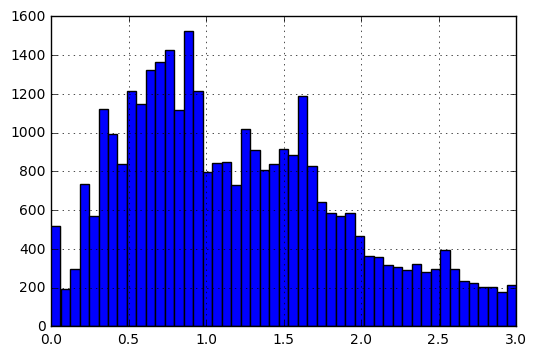

In [27]:
mdf2['z_best'] = mdf2.apply(lambda row: row['Spec_z'] if row['Spec_z']>0 else row['Photo_z_Wuyts'],axis=1)
mdf2['z_best'].hist(bins=np.linspace(0,3))

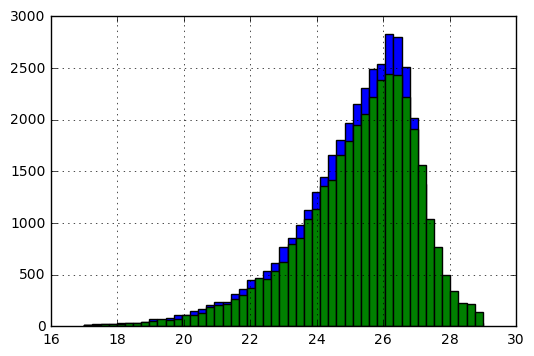

In [97]:
# 28 FLUX AUTO F160W SExtractor Kron-Aperture flux F160W (microJansky)
mdf2['F160W_Kron'] = -2.5*np.log10(mdf2['FLUX_AUTO_F160W']*10**(-6)/3631)
mdf2['F160W_Kron'].hist(bins=np.linspace(17,29))

mdf2['F125W_Kron'] = -2.5*np.log10(mdf2['FLUX_AUTO_F125W']*10**(-6)/3631)
mdf2['F125W_Kron'].hist(bins=np.linspace(17,29))

In [102]:
mdf2.to_csv('cos_df_all_merged.csv',index=False)

In [98]:
z_thresh = 0.1
mdf2['HLR'] = mdf2['FLUX_RADIUS_2_F125W']
mdf2['RA'] = mdf2['RA_x']
mdf2['DEC'] = mdf2['DEC_x']
cos_df_z2 = mdf2[abs(mdf2['z_best']-1.98) < z_thresh]
print len(cos_df_z2)

cos_df_z2_filt = cos_df_z2[cos_df_z2['F125W_Kron']<24]
cos_df_z2_filt_all = cos_df_z2_filt
print len(cos_df_z2_filt)

cos_df_z2_filt = cos_df_z2_filt[(cos_df_z2_filt['dn']/cos_df_z2_filt['n'])<0.2]
print len(cos_df_z2_filt)

1574
260
194


In [99]:
len(cos_df_z2_filt_all)
cos_df_z2_filt_all.to_csv('cos_z2_thresh0p1_all.csv',index=False)

In [100]:
cos_df_z2_filt.to_csv('cos_z2_thresh0p1_err0p2.csv',index=False)

In [86]:
pd.read_csv('cos_z2_thresh0p1_err0p2.csv')

,ID,IAU_designation,RA_x,DEC_x,APCOR,CFHT_uS_FLUX,CFHT_uS_FLUXERR,CFHT_gS_FLUX,CFHT_gS_FLUXERR,CFHT_rS_FLUX,...,n,dn,q,dq,pa,dpa,sn,z_best,F160W_Kron,HLR
0,185,CANDELS_COSMOS_F160W_J100017.52+021052.3,150.073002,2.181218,1.12213,0.279508,0.018132,0.472540,0.019696,0.527566,...,1.1638,0.129342,0.4712,0.030740,-25.0747,2.085290,63.9075,1.936,23.185852,4.566
1,453,CANDELS_COSMOS_F160W_J100030.09+02117.53,150.125403,2.185425,1.00164,0.031588,0.009840,0.067665,0.008975,0.226997,...,1.9126,0.096846,0.4439,0.015323,-11.8707,1.509370,159.5590,2.027,21.618404,4.084
2,801,CANDELS_COSMOS_F160W_J100047.40+021124.5,150.197511,2.190162,1.05139,0.207395,0.015275,0.370626,0.017746,0.432742,...,1.6181,0.256493,0.7248,0.043289,3.3650,4.461290,61.0685,1.967,23.349233,3.655
3,854,CANDELS_COSMOS_F160W_J100033.47+021126.5,150.139466,2.190714,1.02547,0.027299,0.009126,0.042058,0.007057,0.137333,...,3.0011,0.485618,0.6369,0.046070,44.7884,6.031810,83.9967,1.934,22.852404,2.992
4,864,CANDELS_COSMOS_F160W_J100045.72+021126.3,150.190505,2.190650,1.10927,0.122252,0.012331,0.270576,0.015165,0.368799,...,0.8587,0.121956,0.4939,0.026251,45.4017,2.001690,53.9403,2.012,23.030858,5.731
5,998,CANDELS_COSMOS_F160W_J100040.01+021129.8,150.166715,2.191634,1.07364,0.348720,0.019033,0.632784,0.021959,0.862865,...,0.6057,0.036907,0.2560,0.010549,-65.0906,0.769819,114.0710,1.919,22.470922,8.891
6,1333,CANDELS_COSMOS_F160W_J100016.59+021138.2,150.069137,2.193951,1.30561,0.034178,0.012347,0.176477,0.012508,0.333982,...,2.9366,0.249821,0.5708,0.024048,41.3288,2.599680,120.9520,1.913,21.730839,9.127
7,1359,CANDELS_COSMOS_F160W_J100039.06+021145.6,150.162772,2.196018,1.02713,0.054796,0.010710,0.090052,0.010316,0.117134,...,3.6861,0.351872,0.7026,0.026948,-2.1940,2.940970,118.0890,1.891,22.197623,3.946
8,1712,CANDELS_COSMOS_F160W_J100034.30+02120.48,150.142958,2.200135,1.13762,0.053017,0.011069,0.079092,0.010542,0.121235,...,8.0000,1.589180,0.5788,0.061493,-42.9334,7.368980,65.8281,1.942,22.772078,4.159
9,1728,CANDELS_COSMOS_F160W_J100012.60+02120.47,150.052534,2.200131,1.15164,0.105500,0.011610,0.123224,0.010060,0.232290,...,4.4497,0.681291,0.7124,0.035599,-8.9020,3.375440,61.4089,1.973,22.160399,6.022


In [66]:
cos_df_z2_filt['KRON_RADIUS'] # 0.3''/pixel is the final mosaic pixel scale (Nayyeri+2016)

184     4.05
452     3.50
800     3.50
853     3.50
863     3.87
997     4.46
1332    4.84
1358    3.65
1711    4.22
1727    4.48
1917    3.50
2002    4.07
2013    3.50
2092    3.50
2232    5.77
...
24442    3.90
25393    4.13
25495    3.53
25552    3.78
25843    4.25
26150    3.60
26271    4.00
27114    3.50
27514    3.50
27568    4.67
27760    3.50
27950    4.04
28035    3.51
28241    3.50
28277    4.87
Name: KRON_RADIUS, Length: 203, dtype: float64

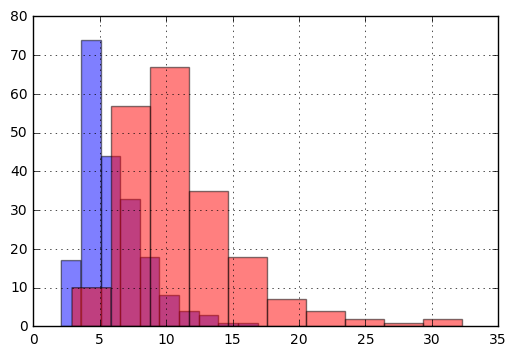

In [81]:
cos_df_z2_filt['FLUX_RADIUS_2_F160W'] # F160W half light radius in pixels (Nayyeri+2016)
# 0.06''/pixel? Nayyeri+2016 p7
# Scale of the candels published mosaic
cos_df_z2_filt['FLUX_RADIUS_2_F160W'].hist(alpha=0.5)
cos_df_z2_filt['FLUX_RADIUS_3_F160W'].hist(alpha=0.5,color='red')

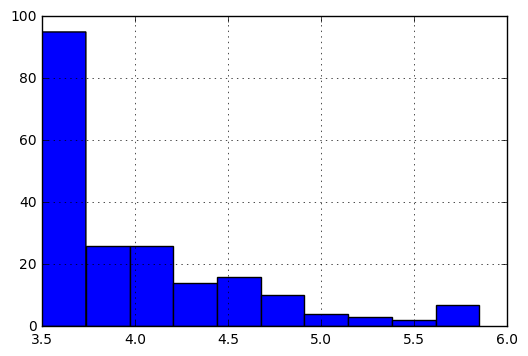

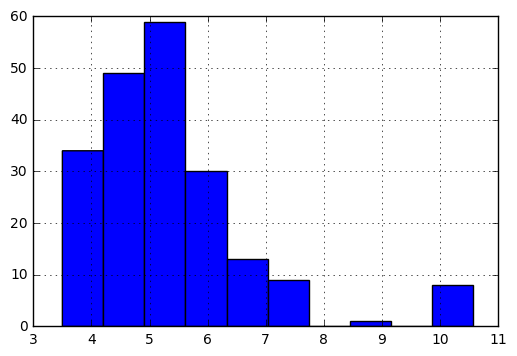

In [82]:
cos_df_z2_filt['KRON_RADIUS'].hist() # 0.3''/pixel is the final mosaic pixel scale (Nayyeri+2016)
plt.show()
cos_df_z2_filt['PETRO_RADIUS'].hist() # 0.3''/pixel is the final mosaic pixel scale (Nayyeri+2016)

------------------
#### Aside: plot 1d sersic profiles

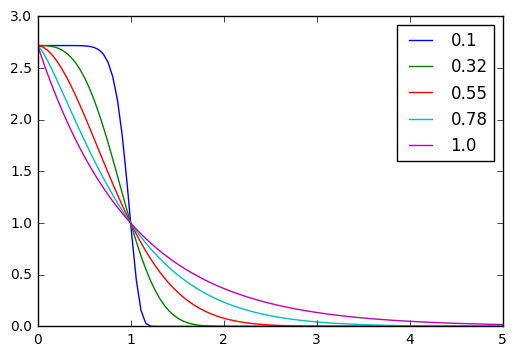

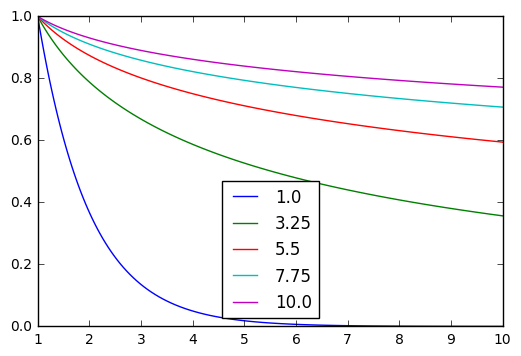

In [53]:
r = np.linspace(0,5,100)
for n in np.linspace(0.1,1,5):
    I = np.exp(-((r)**(1/n)-1))
    plt.plot(r,I,label=n.round(2))
plt.legend(loc='best')

# plt.xscale('log')
# plt.yscale('log')
plt.show()

r = np.logspace(0,1,100)
for n in np.linspace(1,10,5):
    I = np.exp(-((r)**(1/n)-1))
    plt.plot(r,I,label=n.round(2))
plt.legend(loc='best')

# plt.xscale('log')
# plt.yscale('log')
plt.show()

-------------

0     24.879585
1     25.484592
2     24.848809
3     23.867298
4     25.850031
5     25.477680
6     25.642745
7     24.954838
8     24.757055
9     24.554992
10    26.073765
11    26.034970
12    25.794035
13    24.450593
14    24.737368
...
38656    26.817670
38657    26.716667
38658    26.461005
38659    26.951046
38660    26.724483
38661    27.374051
38662    26.751021
38663    26.320141
38664    26.778575
38665    26.503453
38666    26.065213
38667    26.556865
38668    26.012143
38669    26.482515
38670    27.198298
Name: F160W_Kron, Length: 38671, dtype: float64